# Practical 7: Technology adjusted Carbon Based Accounting

Objectives
- Calculate TCBA
- Calculate Scope 1, 2, 3 emissions
- Visualize results

**Technology adjusted consumption-based accounting**

- In the [supplementary Information](https://static-content.springer.com/esm/art%3A10.1038%2Fnclimate2555/MediaObjects/41558_2015_BFnclimate2555_MOESM453_ESM.xlsx) file of [Kander et al. (2015), *National greenhouse-gas accounting for effective climate policy on international trade*](https://www.nature.com/articles/nclimate2555#Tab1), the authors illustrated the TCBA calculation and results in a spreadsheet.

- Download and go through the spreadsheet example to further understand the TCBA calculations. 


In [4]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1: Calculate and visualize CBA vs TCBA

### 1.1 Import the downloaded data

In [5]:
# Import exiobase
data_file = 'data/41558_2015_BFnclimate2555_MOESM453_ESM.xlsx'    # add name of folder where data is stored

Z = pd.read_excel(data_file, sheet_name='TCBA Example', header = 2, usecols='C:N', nrows=12).values

Y = pd.read_excel(data_file, sheet_name='TCBA Example', header = 2, usecols='P:R', nrows=12).values

V = pd.read_excel(data_file, sheet_name='TCBA Example', header = 15, usecols='C:N', nrows=3).sum(0).values

F = pd.read_excel(
    data_file, sheet_name="TCBA Example", header=21, usecols="C:N", nrows=1
).values[0]

c:\Users\fdona\anaconda3\envs\env_advanced_eeio\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1.2 Calculate other IO variables

In [6]:
x = Z.sum(1) + Y.sum(1)
f = F/x
A = Z/x
I = np.eye(A.shape[0])
L = np.linalg.inv(I - A)

### 1.3 TCBA calculations

#### 1.3.1 Export-related output

In [7]:
# output multiplier
x_mult = L @ Y
x_mult

array([[1884.99914448, 2675.85882213, 2340.03299151],
       [1973.52285678, 2389.96249768, 2293.60687569],
       [1949.73444583, 2674.10946478, 2894.01234802],
       [2071.35736233, 3053.88678288, 2742.85823049],
       [2291.03613965, 2592.86995202, 2980.42777823],
       [3322.02479378, 3155.49154411, 3033.76588867],
       [1821.00196378, 2392.20958819, 2903.5998466 ],
       [2283.14542255, 2089.32196886, 2304.07982691],
       [2184.68867051, 2467.62052168, 2429.26820175],
       [2016.80495015, 1863.32313603, 2564.79496106],
       [1926.43419023, 2799.10387779, 2600.88030532],
       [2533.15335664, 3068.77056268, 3009.77261416]])

In [8]:
# remove domestic trasactions (the diagonals)
ex_mult = x_mult.copy()

no_regions = 3  # number of regions
no_sectors = 4  # number of sectors

for i in range(no_regions):
    row_start = i * no_sectors
    row_end= (i + 1) * no_sectors

    ex_mult[ row_start : row_end ,i] = 0           

ex_mult

array([[   0.        , 2675.85882213, 2340.03299151],
       [   0.        , 2389.96249768, 2293.60687569],
       [   0.        , 2674.10946478, 2894.01234802],
       [   0.        , 3053.88678288, 2742.85823049],
       [2291.03613965,    0.        , 2980.42777823],
       [3322.02479378,    0.        , 3033.76588867],
       [1821.00196378,    0.        , 2903.5998466 ],
       [2283.14542255,    0.        , 2304.07982691],
       [2184.68867051, 2467.62052168,    0.        ],
       [2016.80495015, 1863.32313603,    0.        ],
       [1926.43419023, 2799.10387779,    0.        ],
       [2533.15335664, 3068.77056268,    0.        ]])

In [9]:
# The total product output for only export 
ex = ex_mult.sum(1)
ex

array([5015.89181364, 4683.56937337, 5568.1218128 , 5796.74501337,
       5271.46391788, 6355.79068245, 4724.60181039, 4587.22524946,
       4652.30919219, 3880.12808617, 4725.53806802, 5601.92391932])

#### 1.3.2 Export-related emissions

In [10]:
# Export-related emissions
F_ex = f*ex
F_ex

array([218.05409667, 225.13466055, 207.38280355, 294.69596284,
       268.12004704, 213.83583937, 132.7729947 , 103.05982492,
       262.78378013, 138.4701498 , 257.99990267, 325.25088974])

#### 1.3.3 Calculate 'World market average emissions multiplier'

In [11]:
# Split the ex and F into 3 arrays, one for each region 
sect_ex = np.array_split(ex, no_regions)
sect_F_ex = np.array_split(F_ex, no_regions)
sect_ex, sect_F_ex

([array([5015.89181364, 4683.56937337, 5568.1218128 , 5796.74501337]),
  array([5271.46391788, 6355.79068245, 4724.60181039, 4587.22524946]),
  array([4652.30919219, 3880.12808617, 4725.53806802, 5601.92391932])],
 [array([218.05409667, 225.13466055, 207.38280355, 294.69596284]),
  array([268.12004704, 213.83583937, 132.7729947 , 103.05982492]),
  array([262.78378013, 138.4701498 , 257.99990267, 325.25088974])])

In [12]:
# Sum them over axis 0, in this way you have the total global ex and F_ex by sector
sect_ex_sum = np.sum(sect_ex, 0)
sect_F_ex_sum = np.sum(sect_F_ex, 0)
sect_ex_sum, sect_F_ex_sum

(array([14939.66492371, 14919.48814199, 15018.26169121, 15985.89418216]),
 array([748.95792384, 577.44064972, 598.15570091, 723.0066775 ]))

In [13]:
# calculate the average global environmental intensity by sector
f_wa_sec = sect_F_ex_sum / sect_ex_sum
f_wa_sec

array([0.05013218, 0.03870378, 0.03982856, 0.04522779])

In [14]:
# replicate it for each region
f_wa = np.tile(f_wa_sec, no_regions)
f_wa

array([0.05013218, 0.03870378, 0.03982856, 0.04522779, 0.05013218,
       0.03870378, 0.03982856, 0.04522779, 0.05013218, 0.03870378,
       0.03982856, 0.04522779])

#### 1.3.4 Export-related emissions by TCBA

In [15]:
# Export-related emissions by TCBA  
F_ex_TCBA = f_wa*ex
F_ex_TCBA

array([251.4575754 , 181.27185841, 221.77026038, 262.17397067,
       264.26996132, 245.99315112, 188.17407537, 207.47006384,
       233.23038712, 150.17564019, 188.21136516, 253.36264299])

#### 1.3.5 Adjust export-related emissions (i.e. TCBA)

In [16]:
CBA = f @ L @ Y  # note F_hh is neglected in this example
CBA

array([1133.12555364, 1375.14751288, 1391.72693348])

In [17]:
# calculate the different between the total emissions due to exports from the technolgy adjusted ones 
diff_ex = F_ex - F_ex_TCBA
diff_ex

array([ -33.40347873,   43.86280214,  -14.38745683,   32.52199217,
          3.85008572,  -32.15731175,  -55.40108067, -104.41023892,
         29.55339301,  -11.70549039,   69.7885375 ,   71.88824675])

In [18]:
# We aggregate this difference regionally
diff_ex_r = np.sum(np.split(diff_ex, no_regions), axis=1)
diff_ex_r

array([  28.59385876, -188.11854563,  159.52468687])

In [19]:
# Calculate the TCBA
TCBA = CBA + diff_ex_r
TCBA

array([1161.7194124 , 1187.02896725, 1551.25162035])

### 1.4 Visualize results

In [20]:
results = np.concatenate([[CBA], [TCBA]])
results

array([[1133.12555364, 1375.14751288, 1391.72693348],
       [1161.7194124 , 1187.02896725, 1551.25162035]])

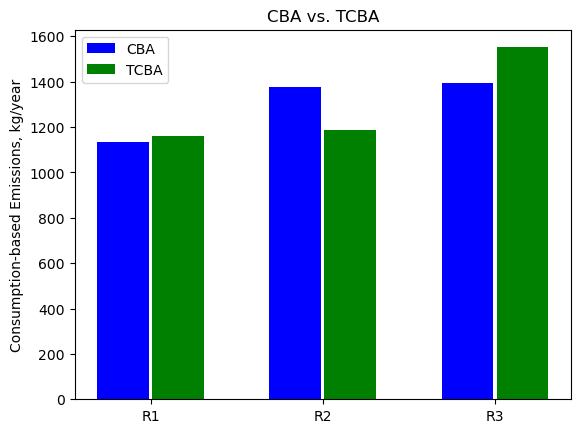

In [21]:
# Plotting the figure
fig = plt.figure()

# settings and positioning of the bars
X_axis_pos = np.arange(no_regions)
plt.bar(X_axis_pos - 0.16, results[0], color = 'b', width = 0.3)
plt.bar(X_axis_pos + 0.16, results[1], color = 'g', width = 0.3)

#axis labels
plt.ylabel('Consumption-based Emissions, kg/year')
plt.xticks(X_axis_pos, ['R1', 'R2', 'R3'])

# Title of the graph
plt.title('CBA vs. TCBA')

# Legend
plt.legend(labels=['CBA', 'TCBA'])

## Exercise 2: Calculate emissions in the different scopes using exiobase

### 2.1 Import exiobase and calculate all the IO variables

In [22]:
# Import exiobase
path = 'data/IOT_2019_pxp/'    # add name of folder where data is stored                                
A = pd.read_csv(f'{path}A.txt', sep='\t', index_col=[0, 1], header=[0, 1])  # A matrix
Y = pd.read_csv(f'{path}Y.txt', sep='\t', index_col=[0, 1], header=[0, 1])  # Y matrix
F = pd.read_csv(f'{path}satellite/F.txt', sep='\t', index_col=[0], header=[0, 1])  # satellite matrix
F_hh = pd.read_csv(f'{path}satellite/F_Y.txt', sep='\t', index_col=[0], header=[0, 1])  # satellite for FD matrix

In [23]:
# calculate the Leontief inverse
I = np.identity(A.shape[0])
L = np.linalg.inv(I - A)

# Calculate total output vector (x)
y_total = Y.sum(1)
x = L @ y_total

In [24]:
# Get the CO2 emissions by combustion ("CO2 - combustion - air")
F_CO2 = F.loc["CO2 - combustion - air"]

In [25]:
# we make a copy of our product output vector
x_inv = x.copy() 

# we divide 1 by the values that are non-0
x_inv[x_inv!=0] = 1/x_inv[x_inv!=0]


In [26]:
f_CO2 = F_CO2 * x_inv

#### 2.2 Calculate CO2 multiplier from exiobase data

In [27]:
f_CO2_mult = f_CO2 @ L

In [28]:
F_CO2_ind = f_CO2_mult @ A @ np.diag(x)

#### 2.3 Import IPCC concordancy matrix

In [29]:
ipcc_data = "data/IPCCsec.xlsx"

# import the xio2detail data
IPCCagg = pd.read_excel(ipcc_data, "xio2detail", header=0, usecols="A:H")
IPCCagg = IPCCagg.set_index("B2:H201")  # Set the first column as the index.
IPCCagg = IPCCagg.rename_axis(None, axis=0)  # Remove the 'B2:H201' name, this is only used for MATLAB code.
IPCCagg = IPCCagg.fillna(0)  # Change NaN into 0.

In [30]:
# This is what the concordancy looks like:
IPCCagg.head()

,Energy,Transport,Materials,Industry,Services,Buildings,AFOLU+
"""Paddy rice""",0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""Wheat""",0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""Cereal grains nec""",0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""Vegetables, fruit, nuts""",0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""Oil seeds""",0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
# This is its shape
IPCCagg.shape

(200, 7)

#### 2.4 Calculate scope 1 emissions

In [40]:
# use np.reshape to organize your array in a sector by region format
co2_x = np.reshape(F_CO2.values, (no_sectors, no_regions), order="F")

co2_x.shape

(200, 49)

In [58]:
# Aggregating sectors/products by the macro-categories  using the concordancy matrix
co2_scope1 = co2_x.T @ IPCCagg

# adding regional labels
reg_labels = Y.index.to_frame(False).region.unique()
co2_scope1.index = reg_labels

# inspecting the data
co2_scope1.head()

,Energy,Transport,Materials,Industry,Services,Buildings,AFOLU+
AT,2.016691e+10,7.935311e+09,6.811139e+09,3.586308e+09,5.746632e+09,2.185800e+09,2.365656e+09
BE,2.048556e+10,1.104956e+10,1.000129e+10,5.517042e+09,8.900914e+09,9.972432e+08,1.044853e+10
BG,2.372672e+10,1.771636e+09,3.393362e+09,1.506501e+09,1.601384e+09,5.960901e+08,1.014416e+09
CY,2.625091e+09,7.148056e+09,6.011065e+08,9.574919e+07,1.926194e+08,3.973396e+07,1.914441e+08
CZ,5.130931e+10,8.740575e+09,1.008320e+10,5.529104e+09,7.297626e+09,2.525981e+09,2.972868e+09


#### 2.5 Calculate scope 2 emissions

In [32]:
# Create the elec array.
no_sectors = 200
no_regions = 49

first_el_pr_pos = 127 # first electricity product category
last_el_pr_pos = 140  # last electricity product category

elec = np.zeros(A.shape[0])

for i in range(no_regions):
    start_pos = i * no_sectors + first_el_pr_pos
    end_pos = i * no_sectors + last_el_pr_pos
    elec[start_pos : end_pos] = 1

In [61]:
co2_elec_Z = f_CO2_mult @ np.diag(elec) @ A @ np.diag(x)

co2_elec_z = np.reshape(co2_elec_Z, (no_sectors, no_regions), order="F")

co2_scope2 = co2_elec_z.T @ IPCCagg

# adding regional labels
reg_labels = Y.index.to_frame(False).region.unique()
co2_scope2.index = reg_labels

# inspecting the data
co2_scope2.head()

,Energy,Transport,Materials,Industry,Services,Buildings,AFOLU+
AT,8.262385e+09,2.250841e+08,8.844044e+08,6.511058e+08,1.013901e+09,3.561049e+08,4.924218e+08
BE,1.115845e+09,2.607817e+08,3.426164e+09,1.017822e+09,1.283272e+09,6.029298e+08,1.071915e+09
BG,3.430876e+09,6.789487e+08,4.089353e+09,3.138016e+09,5.416024e+08,5.675817e+08,1.834307e+09
CY,1.998850e+07,9.778393e+06,2.510536e+08,4.129196e+08,1.012026e+09,2.782214e+08,6.639656e+08
CZ,1.304268e+09,4.109808e+08,1.431851e+09,2.183612e+09,1.706475e+09,3.427689e+08,8.094304e+08


#### 2.6 Calculate scope 3 emissions

In [68]:
co2_ind_shaped = np.reshape(F_CO2_ind, (no_sectors, no_regions), order="F")
co2_scope3 = co2_ind_shaped.T @ IPCCagg - co2_scope2.values

# adding regional labels
reg_labels = Y.index.to_frame(False).region.unique()
co2_scope3.index = reg_labels

# inspecting the data
co2_scope3.head()

,Energy,Transport,Materials,Industry,Services,Buildings,AFOLU+
AT,2.733310e+10,6.069888e+09,1.228469e+10,2.198268e+10,2.117284e+10,1.251391e+10,6.392723e+09
BE,1.820710e+10,1.885661e+10,2.218041e+10,2.418857e+10,3.035455e+10,1.647499e+10,1.449188e+10
BG,5.541495e+09,2.730011e+09,1.234898e+10,5.225574e+09,4.644990e+09,4.654598e+09,4.285286e+09
CY,1.037274e+08,3.391930e+08,5.901414e+08,3.572226e+08,2.169875e+09,1.676593e+09,9.066663e+08
CZ,2.906925e+10,1.428672e+10,2.534489e+10,4.430203e+10,3.046052e+10,1.521667e+10,1.225029e+10


#### 2.7 Make a stacked bar plot of the results for a region

<AxesSubplot: title={'center': 'Scopes 2019 - region NL'}, ylabel='Pg CO2 eq'>

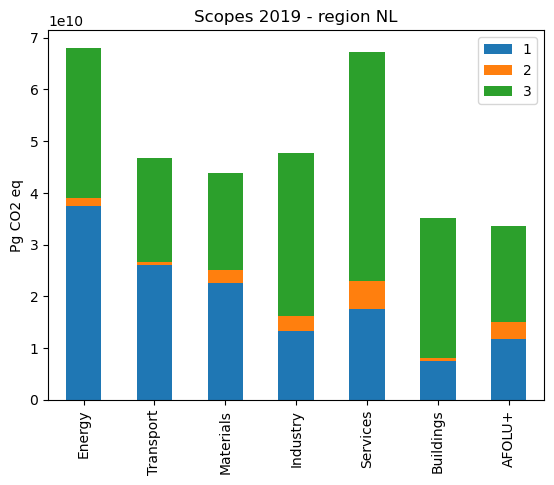

In [79]:
region = "NL"

results_dashboard = pd.DataFrame(
    data=[co2_scope1.loc[region], co2_scope2.loc[region], co2_scope3.loc[region]],
    columns=IPCCagg.columns,
    index=["1", "2", "3"],
)
results_dashboard.T.plot(kind="bar", stacked=True, ylabel="Pg CO2 eq", title=f"Scopes 2019 - region {region}")